<a id="toc"> </a>
<ol> 
    <li> <a href="#importpack"> Import Packages </a> </li>
    <li> <a href="#preparedata"> Prepare Data </a> </li>
    <ol> 
        <li> <a href="#loadquarterlist"> Load Quarters List </a> </li>
        <li> <a href="#addgeolocation"> Add Geo Location </a> </li>
    </ol>
    <li> <a href="#preparequarterprofile"> Prepare Quarter Profile </a> </li>
    <li> <a href="#foursquarevenues"> Foursquare Venues </a> </li>
    <li> <a href="#clustering"> Clustering </a> </li>
    <ol>
        <li> <a href="#kmeans"> K-Means </a> </li>
        <li> <a href="#mapcluster"> Map of Cluster </a> </li>
        <li> <a href="#tablecluster"> Table of clusters </a> </li>
        <li> <a href="#clusteranalysis"> Cluster Analysis </a> </li>
    </ol>

</ol>

## <a id="importpack">Import Packages  <a>

In [25]:

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math

# using default dictionnaries  
from collections import defaultdict

## importing packages for web scrapping
import requests, json
from bs4 import BeautifulSoup

## Geocoding and map drawing
import geocoder
import folium

## 
from shapely.geometry import Point
from shapely.geometry import Polygon

## packages for clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

## wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

print("Import Done")

Import Done


## <a href="#toc" id="preparedata"> Prepare Data </a>

### <a href="#toc" id="loadquarterlist">Load Quarters List </a>

We will retrieve the data from the wikipedia page of Luxembourg quarters. 
Using beautifulSoup we will extract the data from the table and put it into pandas df.

In [26]:
#Wiki url where all the qarters or Luxembourg are listed, with corresponding population
url = "https://en.wikipedia.org/wiki/Quarters_of_Luxembourg_City"


In [27]:
results = requests.get(url)

soup = BeautifulSoup(results.text, features="lxml")

soup_table = soup.table

In [28]:
headers = []
for th in soup_table.find_all("th"):
    if th.text.find("\xa0") > 0:
        headers.append("Population")
    else:
        headers.append(th.text.rstrip())


In [29]:
with open("./data/lux_quartier_centres.geojson", 'r') as f:
    lux_qgis_centres = json.load(f)

In [30]:
data = []

for tr in soup_table.find_all("tr"):
    row = []
    for td in tr.find_all("td"):
        if td.text.find(",") > 0 or td.text.rstrip().isnumeric():
            number = td.text.replace(",", "").rstrip()
            row.append(int(number))
        else:
            row.append(td.text)

    if len(row):
        data.append(row)

We will change the names of some of quarters in order to standartize with other data sources.

In [31]:
lux_data = pd.DataFrame(data, columns=headers)


lux_data['Quarter'].replace(to_replace='North Bonnevoie-Verlorenkost', value='Verlorenkost', inplace=True)
lux_data['Quarter'].replace(to_replace='South Bonnevoie', value='Bonnevoie', inplace=True)
lux_data['Quarter'].replace(to_replace='Ville Haute', value='Ville-Haute', inplace=True)
lux_data['Quarter'].replace(to_replace='Rollingergrund-North Belair', value='Rollingergrund', inplace=True)


In [32]:
lux_data.to_csv("./data/lux_data.csv", index=False)

In [33]:
lux_data.head()

,Quarter,Population
0,Beggen,3746
1,Belair,11494
2,Verlorenkost,4296
3,Bonnevoie,12734
4,Cents,6316


### <a href="#toc" id="addgeolocation"> Add Geo Location </a>

As with geocoder the geographic points found are not always in the centre of the quarter we use geometrical centre of each polygon of quarter.
Basically, from the borders of each quarter we will build polygons and then calculate the centres for each o them. All those steps are done in QGIS Desktop.

In [34]:
lux_geo = lux_data
lux_geo['Latitude'] = None
lux_geo['Longitude'] = None

In [35]:
location_string = "{}, Luxembourg, Luxembourg"

In [36]:
for centre in lux_qgis_centres['features']:
    name = centre['properties']['name']
    lat = centre['geometry']['coordinates'][1]
    lng = centre['geometry']['coordinates'][0]
    lux_geo.at[lux_geo['Quarter'] == name, 'Latitude'] = lat
    lux_geo.at[lux_geo['Quarter'] == name, 'Longitude'] = lng

lux_geo.to_csv("./data/lux_geo.csv", index=False)

In [37]:
luxcoor = geocoder.arcgis(location_string.format("Luxembourg"))
lux_lat = luxcoor.latlng[0]
lux_lng = luxcoor.latlng[1]


We will check the results with the map drawed using folium.

In [38]:
m = folium.Map(location=[lux_lat, lux_lng], zoom_start=11)

In [39]:
for lat, lon, qua in zip(lux_geo['Latitude'], lux_geo['Longitude'], lux_geo['Quarter']):
    label = folium.Popup(str(qua))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True
    ).add_to(m)
    
folium.LayerControl().add_to(m)

In [40]:
m

Next, we will analyse the data for each quarter retrived from the wiki page. The Choropleth chart drawn below presents the population of each quarter.

In [41]:
with open("./chart/lux_quartier.geojson") as f:
    lux_geojson = json.load(f)

In [42]:
def_tiles = ['Stamen Toner', 'Stamen Terrain', 'OpenStreetMap', 'Mapbox Control Room', 'Mapbox Bright']


def style_functions(features):
    quartier = features['properties']['name']
    return {
        'popup': quartier,
        'fillColor': 'YlGn'
    }



In [43]:

m = folium.Map(location=[lux_lat, lux_lng], zoom_start=11)

In [44]:
choro = folium.Choropleth(
    geo_data=lux_geojson,
    name= 'quarter_population',
    data=lux_data,
    columns=['Quarter', 'Population'],
    key_on='properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.5,
    line_opacity=0.9,
    popup='Quarter',
    highlight=True,
    control=True,

)


In [45]:
for t in def_tiles:
    folium.TileLayer(tiles=t).add_to(m)

In [46]:
choro.add_to(m)

In [47]:
folium.LayerControl().add_to(m)
m

In [48]:
m.save("./chart/quarter_pop.html")

### <a href="#toc" id="preparequarterprofile"> Prepare Quarter Profile </a>

### Load the nationalities and enhance the initial data

We will load three datasets. "StatsPopulation" with the data about information for each quarter, "Nationalities_ISO3" is the list of countries where each "nationality_code" from StatsPopulation" is matched to the alpha-3 code and the nationality (in french). "all_countries" is the list all countries and their full name.

In [49]:
stats_popu = pd.read_csv("./data/StatsPopulation_20161231.csv", sep=';', encoding='latin_1' )
countries = pd.read_csv("./data/Nationalites_ISO3_Nom.csv", sep=';', encoding='latin_1')
countries_info = pd.read_csv("./data/all_countries.csv")

In [50]:
stats_popu.rename(columns={"Nationality": "nationality_code"}, inplace=True)

In [51]:
stats_popu.head()

,Age,Sexe,nationality_code,Quartier
0,54,M,I,MERL
1,3,M,B,GARE
2,49,F,F,KIRCHBERG
3,37,F,TJ,MERL
4,53,M,L,LIMPERTSBERG


In [52]:
tmp = []
for i in stats_popu.index:
    age = stats_popu.at[i, "Age"]
    sex = stats_popu.at[i, "Sexe"]
    nat_code = stats_popu.at[i, "nationality_code"]
    quarter = stats_popu.at[i, "Quartier"]
    if nat_code.find(','):
        nat_codes = nat_code.split(', ')
        for nat in nat_codes:
            row = [age, sex, nat, quarter]
            tmp.append(row)
    else:
        row = [age, sex, nat_codes, quarter]
        tmp.append(row)

stats_multinat = pd.DataFrame(tmp, columns=["Age", "Sex", "nationality_code", "Quarter"])
    

stats_multinat.head()

,Age,Sex,nationality_code,Quarter
0,54,M,I,MERL
1,3,M,B,GARE
2,49,F,F,KIRCHBERG
3,37,F,TJ,MERL
4,53,M,L,LIMPERTSBERG


In [53]:
countries.rename(columns={"NATIONALITE_CODEPAYS": "nationality_code", "NATIONALITE_NOM": "Nationality", "NATIONALITE_ISO3": "alpha3"}, inplace=True)

In [54]:
countries.head()

,nationality_code,alpha3,Nationality
0,A,AUT,autrichienne
1,AFG,AFG,afghane
2,AL,ALB,albanaise
3,AND,AND,andorrane
4,ANG,AGO,angolaise


In [55]:
countries_info.drop(["country-code", "iso_3166-2", "alpha-2", "intermediate-region", "sub-region-code", "intermediate-region-code", "region-code"], axis=1, inplace=True) # remove unnecessary columns
countries_info.rename(columns={"name": "country", "alpha-3": "alpha3"  }, inplace=True)
countries_info.head()

,country,alpha3,region,sub-region
0,Afghanistan,AFG,Asia,Southern Asia
1,Åland Islands,ALA,Europe,Northern Europe
2,Albania,ALB,Europe,Southern Europe
3,Algeria,DZA,Africa,Northern Africa
4,American Samoa,ASM,Oceania,Polynesia


In [56]:
countries_full = countries.set_index("alpha3").join(countries_info.set_index("alpha3"), on="alpha3")

In [57]:
countries_full.reset_index().head()

,alpha3,nationality_code,Nationality,country,region,sub-region
0,AUT,A,autrichienne,Austria,Europe,Western Europe
1,AFG,AFG,afghane,Afghanistan,Asia,Southern Asia
2,ALB,AL,albanaise,Albania,Europe,Southern Europe
3,AND,AND,andorrane,Andorra,Europe,Southern Europe
4,AGO,ANG,angolaise,Angola,Africa,Sub-Saharan Africa


In [58]:
stats_full = stats_multinat.set_index('nationality_code')\
                .join(countries_full.reset_index().
                 set_index('nationality_code'), 
                 on="nationality_code",
                how="inner")
stats_full.shape

(119125, 8)

In [59]:
stats_full = stats_full.dropna()
stats_full = stats_full.reset_index()

stats_full.shape

(118743, 9)

In [60]:
ffun = lambda x : x.capitalize()
stats_full["Quarter"] = stats_full["Quarter"].map(ffun)

In [61]:
stats_full['Quarter'].replace(to_replace='Bonnevoie-nord/verlorenkost', value='Verlorenkost', inplace=True)
stats_full['Quarter'].replace(to_replace='Bonnevoie-sud', value='Bonnevoie', inplace=True)
stats_full['Quarter'].replace(to_replace='Ville-haute', value='Ville-Haute', inplace=True)
stats_full['Quarter'].replace(to_replace='Rollingergrund/belair-nord', value='Rollingergrund', inplace=True)
stats_full['Quarter'].replace(to_replace='Muehlenbach', value='Muhlenbach', inplace=True)
stats_full['Quarter'].replace(to_replace='Neudorf/weimershof', value='Neudorf-Weimershof', inplace=True)
stats_full['Quarter'].replace(to_replace='Pulvermuehl', value='Pulvermuhl', inplace=True)

In [62]:

stats_full.to_csv("./data/lux_residents_by_quarter.csv", index=False,sep=";")
stats_full.head()

,nationality_code,Age,Sex,Quarter,alpha3,Nationality,country,region,sub-region
0,I,54,M,Merl,ITA,italienne,Italy,Europe,Southern Europe
1,I,62,M,Cents,ITA,italienne,Italy,Europe,Southern Europe
2,I,62,M,Belair,ITA,italienne,Italy,Europe,Southern Europe
3,I,62,M,Limpertsberg,ITA,italienne,Italy,Europe,Southern Europe
4,I,62,M,Gare,ITA,italienne,Italy,Europe,Southern Europe


In [63]:
aggregation = {'Age':  'mean', 'Quarter': 'count'}

In [64]:
nat = stats_full.drop(["Sex", "nationality_code", "alpha3", "Nationality", "region", "sub-region"],axis=1).groupby('country').agg(aggregation)

In [65]:
stats_full.to_csv("./data/stats_full.csv", index=False)

In [66]:
nat = nat.reset_index()
nat.sort_values('Quarter', ascending=False, inplace=True)
nat.head()

,country,Age,Quarter
89,Luxembourg,45.391917,33303
53,France,33.512768,20598
118,Portugal,38.849165,13591
74,Italy,38.487839,8511
14,Belgium,39.570642,4905


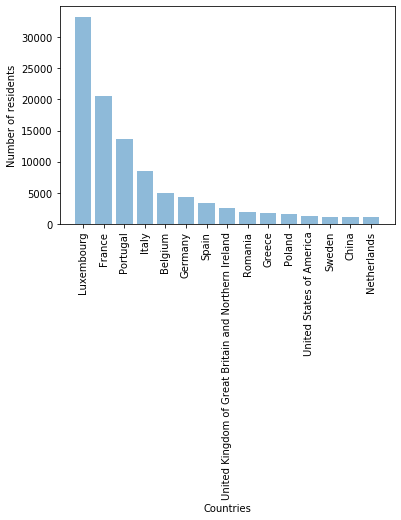

In [67]:
nat = nat[nat["Quarter"]>1000]
plt.bar(nat["country"], nat["Quarter"], align='center', alpha=0.5)
plt.xticks(range(len(nat["country"])), nat["country"], rotation="vertical")
plt.xlabel("Countries")
plt.ylabel("Number of residents")
plt.savefig("./chart/resident_per_country.jpeg", bbox_inches='tight')
plt.savefig("./report/chart/resident_per_country.jpeg", bbox_inches='tight')
plt.show()


In [68]:
sub_reg = stats_full.drop(["Sex", "nationality_code", "alpha3", "Nationality", "region", "country"],axis=1).groupby('sub-region').agg(aggregation)

In [69]:
sub_reg = sub_reg.reset_index()
sub_reg.sort_values('Quarter', ascending=False, inplace=True)
sub_reg.head()

,sub-region,Age,Quarter
14,Western Europe,40.557198,64740
11,Southern Europe,37.559762,29584
7,Northern Europe,35.074993,7574
3,Eastern Europe,31.689814,7157
12,Sub-Saharan Africa,31.449790,1663


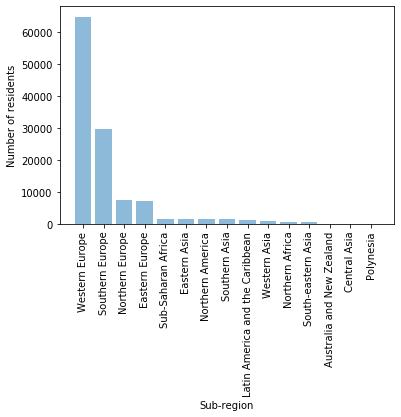

In [70]:
plt.bar(sub_reg["sub-region"], sub_reg["Quarter"], align='center', alpha=0.5)
plt.xticks(range(len(sub_reg["sub-region"])), sub_reg["sub-region"], rotation="vertical")
plt.xlabel("Sub-region")
plt.ylabel("Number of residents")
plt.savefig("./chart/resident_per_region.jpeg", bbox_inches='tight')
plt.savefig("./report/chart/resident_per_region.jpeg", bbox_inches='tight')
plt.show()

In [71]:
worldmap = stats_full[["alpha3", "country", "region"]] 
worldmap = worldmap.groupby(["alpha3", "country"]).count().reset_index()
worldmap["country_present"] = 1
worldmap

,alpha3,country,region,country_present
0,AFG,Afghanistan,84,1
1,AGO,Angola,11,1
2,ALB,Albania,222,1
3,AND,Andorra,2,1
4,ARG,Argentina,58,1
...,...,...,...,...
156,VNM,Viet Nam,64,1
157,WSM,Samoa,1,1
158,YEM,Yemen,1,1
159,ZAF,South Africa,53,1


#### Draw a world map with all countries represented in Luxembourg city.


Note: as the drawing of the map increases the size of the notebook we will comment it out and let the viewer the coice to draw the plot. 

In [75]:
# ## https://github.com/datasets/geo-countries/blob/master/data/countries.geojson
# with open("./chart/countries.geojson") as f:
#     countries_geojson = json.load(f)

In [76]:
# wmap = folium.Map(location=[0, 0], zoom_start=3)

# folium.Choropleth(
#     geo_data=countries_geojson,
#     name='choropleth',
#     data=worldmap,
#     columns=['alpha3', 'country_present'],
#     key_on='feature.properties.ISO_A3',
#     bins=4,
#     fill_color='BrBG',
#     title= "Countries present in Luxembourg City",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Less than 1, no resident from country living in Luxembourg city '
# ).add_to(wmap)


In [77]:
# folium.LayerControl().add_to(wmap)

In [ ]:


# wmap

In [78]:
# wmap.save("./chart/lux_residents_world.html")

##### Prepare the data to join with lux geo

In [79]:
lux_res_profile = stats_full[["Age", "Quarter", "country", "Sex"]]

In [80]:
lux_res_profile = pd.get_dummies(lux_res_profile, 
                                 columns=["Sex", "country"],
                                 prefix="", 
                                 prefix_sep="",
                                dtype=float)

In [81]:
lux_res_profile

,Age,Quarter,F,M,Afghanistan,Albania,Algeria,Andorra,Angola,Argentina,...,Uganda,Ukraine,United Kingdom of Great Britain and Northern Ireland,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zimbabwe
0,54,Merl,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62,Cents,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62,Belair,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,Limpertsberg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,62,Gare,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118738,48,Gare,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118739,58,Hollerich,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118740,33,Hollerich,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118741,30,Gare,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [82]:
lux_res_agg = lux_res_profile.groupby("Quarter").sum().reset_index()


In [83]:
lux_res_agg

,Quarter,Age,F,M,Afghanistan,Albania,Algeria,Andorra,Angola,Argentina,...,Uganda,Ukraine,United Kingdom of Great Britain and Northern Ireland,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zimbabwe
0,Beggen,134498,1786.0,1809.0,1.0,4.0,1.0,0.0,0.0,0.0,...,0.0,15.0,67.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Belair,449062,5935.0,5822.0,19.0,16.0,8.0,0.0,0.0,10.0,...,0.0,13.0,331.0,212.0,1.0,0.0,6.0,3.0,0.0,2.0
2,Bonnevoie,499140,6390.0,6581.0,0.0,17.0,14.0,0.0,5.0,1.0,...,0.0,19.0,146.0,50.0,1.0,1.0,2.0,13.0,0.0,0.0
3,Cents,253261,3374.0,3223.0,3.0,2.0,5.0,0.0,0.0,4.0,...,0.0,17.0,128.0,52.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Cessange,159411,2156.0,2193.0,0.0,0.0,5.0,0.0,0.0,2.0,...,0.0,23.0,64.0,49.0,0.0,0.0,3.0,1.0,0.0,0.0
5,Clausen,39875,463.0,561.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,34.0,19.0,0.0,1.0,1.0,0.0,0.0,0.0
6,Dommeldange,106103,1270.0,1413.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,7.0,82.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0
7,Eich,103125,1331.0,1506.0,12.0,13.0,1.0,1.0,0.0,0.0,...,0.0,12.0,47.0,9.0,0.0,0.0,3.0,8.0,0.0,0.0
8,Gare,401424,4792.0,5772.0,11.0,25.0,14.0,0.0,1.0,2.0,...,1.0,34.0,212.0,60.0,2.0,1.0,11.0,20.0,1.0,1.0
9,Gasperich,221567,2974.0,3043.0,0.0,11.0,12.0,1.0,0.0,3.0,...,0.0,15.0,58.0,26.0,0.0,3.0,1.0,1.0,0.0,1.0


###### Add the countryprofile to lux_geo

In [84]:
lux_quarter_full = lux_geo.set_index("Quarter").join(lux_res_agg\
            .set_index("Quarter"), on="Quarter")\
            .reset_index()

In [85]:
lux_quarter_full

,Quarter,Population,Latitude,Longitude,Age,F,M,Afghanistan,Albania,Algeria,...,Uganda,Ukraine,United Kingdom of Great Britain and Northern Ireland,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zimbabwe
0,Beggen,3746,49.644,6.12882,134498,1786.0,1809.0,1.0,4.0,1.0,...,0.0,15.0,67.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Belair,11494,49.6115,6.10679,449062,5935.0,5822.0,19.0,16.0,8.0,...,0.0,13.0,331.0,212.0,1.0,0.0,6.0,3.0,0.0,2.0
2,Verlorenkost,4296,49.6043,6.14181,163946,2080.0,2267.0,0.0,1.0,5.0,...,0.0,6.0,76.0,30.0,0.0,2.0,4.0,3.0,0.0,0.0
3,Bonnevoie,12734,49.5966,6.14655,499140,6390.0,6581.0,0.0,17.0,14.0,...,0.0,19.0,146.0,50.0,1.0,1.0,2.0,13.0,0.0,0.0
4,Cents,6316,49.6172,6.16433,253261,3374.0,3223.0,3.0,2.0,5.0,...,0.0,17.0,128.0,52.0,0.0,0.0,0.0,1.0,0.0,0.0
5,Cessange,4479,49.5868,6.09611,159411,2156.0,2193.0,0.0,0.0,5.0,...,0.0,23.0,64.0,49.0,0.0,0.0,3.0,1.0,0.0,0.0
6,Clausen,963,49.6139,6.14243,39875,463.0,561.0,0.0,0.0,1.0,...,0.0,1.0,34.0,19.0,0.0,1.0,1.0,0.0,0.0,0.0
7,Dommeldange,2587,49.6431,6.14725,106103,1270.0,1413.0,0.0,1.0,0.0,...,0.0,7.0,82.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0
8,Eich,2961,49.6322,6.13184,103125,1331.0,1506.0,12.0,13.0,1.0,...,0.0,12.0,47.0,9.0,0.0,0.0,3.0,8.0,0.0,0.0
9,Gare,10741,49.6018,6.12964,401424,4792.0,5772.0,11.0,25.0,14.0,...,1.0,34.0,212.0,60.0,2.0,1.0,11.0,20.0,1.0,1.0


In [86]:
lux_quarter_full.to_csv("./data/lux_quarter_full.csv", index=False, sep=";")

## <a href="#toc" id="foursquarevenues"> Foursquare Venues </a>

In [60]:
url = 'https://api.foursquare.com/v2/venues/explore'

In [61]:
radius = 1000

In [62]:
def foursquare_request(latitude, longitude, radius=500, CLIENT_ID="", CLIENT_SECRET="", version='20191109'):
  params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    intent='browse',
    v=version,
    ll="{}, {}".format(latitude, longitude),
    radius=radius,
  )

  resp = requests.get(url=url, params=params)
  data = json.loads(resp.text)


  return data

In [63]:
def foursquare_request(latitude, longitude, radius, CLIENT_ID="", CLIENT_SECRET="", version='20191109'):
  params = dict(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    intent='browse',
    v=version,
    ll="{}, {}".format(latitude, longitude),
    radius=radius,
  )

  resp = requests.get(url=url, params=params)
  data = json.loads(resp.text)

  return data


def list_of_venues(quarter, qlat, qlng, venues, four_response):
  # list through foursquare response and retrieve venues for quarter
  for item in four_response['response']['groups'][0]["items"]:
    quarter = quarter
    if not item['venue']['categories']:
        category = ""
        cat_icon = ""
    else:
        category = item['venue']['categories'][0]['name']
        cat_icon = item['venue']['categories'][0]['icon']["prefix"] + item['venue']['categories'][0]['icon']["suffix"]

    lat = item['venue']['location']["lat"]
    lng = item['venue']['location']["lng"]
    name = item['venue']['name']

    row = [quarter, qlat, qlng, name, category, cat_icon, lat, lng]

    venues.append(row)



In [64]:
quar_poly = defaultdict()
for feature in lux_geojson['features']:
    quar_poly[feature['properties']['name']] = feature['geometry']['coordinates']

In [65]:
ity = "Luxembourg"

lux_venues = []


In [66]:
for i in lux_geo.index:
  quarter = lux_geo.at[i, 'Quarter']
  lat = lux_geo.at[i, 'Latitude']
  lng = lux_geo.at[i, 'Longitude']

  quart_data = foursquare_request(latitude=lat, longitude=lng, radius=radius, CLIENT_ID=CLIENT_ID, CLIENT_SECRET=CLIENT_SECRET)

  list_of_venues(quarter=quarter, qlat=lat, qlng=lng, venues=lux_venues, four_response=quart_data)

#   with open("./data/venues/venues_{}.json".format(quarter), 'w') as f:
#     json.dump(quart_data, f, sort_keys=True, indent=4)
#     # print(quart_data['response'])
#     # list_of_venues(quarter, lux_venues, quart_data['response']['venues'])



In [67]:
columns = ["Quarter", "Quarter_Latitude", "Quarter_Longitude", "Venue", "Category", "Category_Icon",
           "Venue_Latitude", "Venue_Longitude"]
lux_venues_df = pd.DataFrame(lux_venues, columns=columns)

print(lux_venues_df.shape)


(510, 8)


In [68]:
def check_venues_in_polygon(lux_venues_df, quarter_polygons):
  lux_venues_df["In Venue"] = None

  for i, quarter, venue, lat, lng in zip(lux_venues_df.index, lux_venues_df['Quarter'], lux_venues_df['Venue'],
                                         lux_venues_df['Venue_Latitude'], lux_venues_df['Venue_Longitude']):
    lon_lats = np.array(quarter_polygons[quarter][0][0])
    polygon = Polygon(lon_lats)
    point = Point(lng, lat)
    # print("{} is in quarter {} : {}".format(venue, quarter, str(polygon.contains(point))))
    lux_venues_df.at[i, "In Venue"] = polygon.contains(point)


In [69]:
check_venues_in_polygon(lux_venues_df, quar_poly)


In [70]:
lux_venues_df = lux_venues_df[lux_venues_df["In Venue"]]
print(lux_venues_df.groupby("In Venue").count())

          Quarter  Quarter_Latitude  Quarter_Longitude  Venue  Category  \
In Venue                                                                  
True          262               262                262    262       262   

          Category_Icon  Venue_Latitude  Venue_Longitude  
In Venue                                                  
True                262             262              262  


In [71]:
lux_venues_df.to_csv(("./data/lux_venues.csv"), index=False)

## <a href="#toc" id="clustering"> Clustering </a>

Loading the dataframe with the list of venues

In [72]:
lux_venues_df = pd.read_csv("./data/lux_venues.csv")


In [146]:
lux_venues_df.shape

(262, 9)

In [ ]:
lux_quarter_full = pd.read_csv("./data/lux_quarter_full.csv", sep=";")

In [147]:
lux_quarter_full.shape

(24, 168)

In [73]:
lux_venues_onehot = pd.get_dummies(lux_venues_df.drop(["Quarter_Latitude", "Quarter_Longitude", "Venue", "Category_Icon",
                                                    "Venue_Latitude", "Venue_Longitude", "In Venue"], axis=1)
                                   , columns=["Category"], dtype=float, prefix="", prefix_sep="")


In [148]:
lux_venues_onehot.shape

(262, 102)

In [74]:
lux_venues_grouped = lux_venues_onehot.groupby(["Quarter"], as_index=False).sum()

In [75]:
lux_quarter_cluster = lux_quarter_full.drop(["Latitude", "Longitude", "Population"], axis=1).set_index("Quarter")\
                        .join(lux_venues_grouped.set_index("Quarter"), on="Quarter").reset_index()



In [76]:
lux_quarter_cluster

,Quarter,Age,F,M,Afghanistan,Albania,Algeria,Andorra,Angola,Argentina,...,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar
0,Beggen,134498,1786.0,1809.0,1.0,4.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Belair,449062,5935.0,5822.0,19.0,16.0,8.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Verlorenkost,163946,2080.0,2267.0,0.0,1.0,5.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bonnevoie,499140,6390.0,6581.0,0.0,17.0,14.0,0.0,5.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cents,253261,3374.0,3223.0,3.0,2.0,5.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Cessange,159411,2156.0,2193.0,0.0,0.0,5.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Clausen,39875,463.0,561.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Dommeldange,106103,1270.0,1413.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Eich,103125,1331.0,1506.0,12.0,13.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Gare,401424,4792.0,5772.0,11.0,25.0,14.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [77]:
logtemp = np.array(lux_quarter_cluster.loc[:,'Age': ])
logtemp = np.ma.log(logtemp)

In [78]:
lux_quarter_cluster_log = lux_quarter_cluster
lux_quarter_cluster_log.loc[:,'Age': ] = logtemp
lux_quarter_cluster_log = lux_quarter_cluster_log.replace(np.inf, 0)

In [79]:
lux_quarter_cluster_log.to_csv("./data/lux_quarter_for_cluster.csv", index=False)

In [80]:
lux_quarter_cluster_log

,Quarter,Age,F,M,Afghanistan,Albania,Algeria,Andorra,Angola,Argentina,...,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar
0,Beggen,11.809305,7.487734,7.500529,0.000000,1.386294,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Belair,13.014916,8.688622,8.669399,2.944439,2.772589,2.079442,0.0,0.000000,2.302585,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Verlorenkost,12.007292,7.640123,7.726213,0.000000,0.000000,1.609438,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bonnevoie,13.120642,8.762490,8.791942,0.000000,2.833213,2.639057,0.0,1.609438,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cents,12.442176,8.123854,8.078068,1.098612,0.693147,1.609438,0.0,0.000000,1.386294,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Cessange,11.979241,7.676010,7.693026,0.000000,0.000000,1.609438,0.0,0.000000,0.693147,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Clausen,10.593505,6.137727,6.329721,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Dommeldange,11.572166,7.146772,7.253470,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Eich,11.543697,7.193686,7.317212,2.484907,2.564949,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Gare,12.902774,8.474703,8.660774,2.397895,3.218876,2.639057,0.0,0.000000,0.693147,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]


In [82]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Quarter']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


In [83]:
lux_quarter_sorted = pd.DataFrame(columns=columns)
lux_quarter_sorted['Quarter'] = lux_venues_grouped['Quarter']


In [84]:

for ind in np.arange(lux_venues_grouped.shape[0]):
    lux_quarter_sorted.iloc[ind, 1:] = return_most_common_venues(lux_venues_grouped.iloc[ind, :], num_top_venues)


### <a href="#toc" id="kmeans"> K-Means </a>

In [85]:
kmeans = KMeans(random_state=1234)

In [86]:
param_grid =[
    {"n_clusters": list(range(1, 10))}
]


In [87]:

kmeans_grid = GridSearchCV(kmeans, param_grid)

In [152]:

X = lux_quarter_cluster.drop(["Quarter"], axis=1)
X = X.to_numpy()


In [153]:
X.shape

(24, 265)

In [154]:
pca = PCA(n_components=18)

In [155]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [156]:
np.sum(pca.explained_variance_ratio_)

0.9611885334687862

In [187]:
Xpca = pca.fit_transform(X)

In [191]:
Xpca.shape

(24, 18)

In [158]:
kmeans_grid.fit(Xpca)

GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=1234, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [159]:
kmeans_be =kmeans_grid.best_estimator_

In [160]:
kmeans_be

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [161]:
# Lux merged
# lux_quarter_sorted.insert(loc=0, column="Cluster", value=kmeans_be.labels_)

lux_quarter_merged = lux_quarter_full[["Quarter", "Latitude", "Longitude"]]
lux_quarter_merged = lux_quarter_merged.rename(columns={'Latitude':'Quarter_Latitude', 'Longitude': 'Quarter_Longitude'})
lux_quarter_merged = lux_quarter_merged.join(lux_quarter_cluster.set_index('Quarter'), on='Quarter')
lux_quarter_merged.insert(loc=0, column="Cluster", value=kmeans_be.labels_)

lux_quarter_merged.to_csv("./data/lux_clusters_merged.csv", index=False)


### <a href="#toc" id="mapcluster"> Build map of clusters </a>

In [162]:
latitude, longitude = 49.6113, 6.1293
m = folium.Map(location=[latitude, longitude], zoom_start=12)

In [163]:
folium.GeoJson(lux_geojson, name="Borders").add_to(m)
#

In [164]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


In [165]:


for quarter, lat, lng, cluster in zip(lux_quarter_merged["Quarter"], lux_quarter_merged["Quarter_Latitude"],
                                           lux_quarter_merged["Quarter_Longitude"], lux_quarter_merged["Cluster"]):
    folium.CircleMarker(
        location=[lat, lng],
        radius= 10,
        popup="{} \ncluster: {}".format(quarter, cluster),
        fill = True,
        fill_color = colors[int(cluster)],
        color = colors[int(cluster)],
        fill_opacity = 1
    ).add_to(m)


In [166]:
folium.LayerControl().add_to(m)


In [167]:
m

In [168]:
m.save("./chart/lux_kmeans.html")

### <a href="#toc" id="tablecluster"> Table of clusters </a>

In [169]:
tab = lux_quarter_merged[['Quarter', 'Cluster']]

In [170]:
tab.sort_values("Cluster")

,Quarter,Cluster
0,Beggen,0
21,Rollingergrund,0
2,Verlorenkost,0
5,Cessange,0
10,Gasperich,0
8,Eich,0
20,Pulvermuhl,1
19,Pfaffenthal,1
12,Hamm,1
11,Grund,1


In [171]:
tab.sort_values("Cluster").to_csv("./data/Clusters.csv", index=False)

### <a href="#toc" id="clusteranalysis"> Cluster Analysis </a>

In [172]:
## Worldcloud

In [173]:
lux_quarter_merged = pd.read_csv("./data/lux_clusters_merged.csv")


### 

In [174]:
lux_venues_df = pd.read_csv("./data/lux_venues_df.csv")
lux_venues_df.head()

,Quarter,Quarter_Latitude,Quarter_Longitude,Venue,Category,Category_Icon,Venue_Latitude,Venue_Longitude,In Venue
0,Beggen,49.644031,6.128825,Jim's Fitness,Gym,https://ss3.4sqi.net/img/categories_v2/buildin...,49.645746,6.127744,True
1,Beggen,49.644031,6.128825,Tandoori,Indian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/in...,49.645267,6.128516,True
2,Beggen,49.644031,6.128825,Lidl,Supermarket,https://ss3.4sqi.net/img/categories_v2/shops/f...,49.646564,6.128442,True
3,Beggen,49.644031,6.128825,Cactus Bereldange,Shopping Mall,https://ss3.4sqi.net/img/categories_v2/shops/m...,49.650288,6.127012,False
4,Beggen,49.644031,6.128825,Pizza Hut,Pizza Place,https://ss3.4sqi.net/img/categories_v2/food/pi...,49.644888,6.129021,True


In [175]:
tmp = lux_venues_df[["Quarter", "Category", "Venue"]]

In [176]:
tmp = tmp.groupby(["Quarter", "Category"]).count().reset_index()


In [177]:
tmp2 = tmp.set_index('Quarter').join(lux_quarter_merged.set_index('Quarter').drop(lux_quarter_merged.columns[2:], axis=1), on ='Quarter').reset_index()

In [178]:
wrd_cloud = defaultdict()

In [179]:
for i in tmp2.index:
    clus = tmp2.at[i, 'Cluster']
    cat = tmp2.at[i, 'Category']
    freq = tmp2.at[i, 'Venue']
    if clus in wrd_cloud:
        wrd_cloud[clus]["venue"][cat] = freq
    else:
        wrd_cloud[clus] = {"venue": {}, "country": {}}
        wrd_cloud[clus]["venue"]= {cat : freq}
    

In [180]:
tmp = stats_full[["Quarter", "country", "alpha3"]]

In [181]:
tmp = tmp.groupby(["Quarter", "country"]).count().reset_index()


In [182]:
tmp3 = tmp.set_index('Quarter').join(lux_quarter_merged.set_index('Quarter').drop(lux_quarter_merged.columns[2:], axis=1), on ='Quarter').reset_index()

In [183]:
for i in tmp3.index:
    clus = tmp3.at[i, 'Cluster']
    cat = tmp3.at[i, 'country']
    freq = tmp3.at[i, 'alpha3']
    if clus in wrd_cloud:
        wrd_cloud[clus]["country"][cat] = freq
    else:
        wrd_cloud[clus]["country"]= {cat : freq}


In [184]:
wrd_cloud.keys()

dict_keys([0, 5, 3, 2, 1, 4])

In [197]:
fig = plt.figure(figsize=[100,200])
fig.subplots_adjust(hspace=0.00, wspace=0.1)
rows = math.floor(len(list(wrd_cloud.keys()))/4)

figs = 0
for i in range(0, max(wrd_cloud.keys())+1):
    wcven = WordCloud(background_color="white", relative_scaling=0
              ).generate_from_frequencies(frequencies=wrd_cloud[i]["venue"])
    wccoun = WordCloud(background_color="white", relative_scaling=0
              ).generate_from_frequencies(frequencies=wrd_cloud[i]["country"])
    
    axeven = fig.add_subplot(6, 2,figs+1)
    axeven.imshow(wcven, interpolation="none")
    axeven.axis("off")
#     axe.text(0,0, "Wordcloud for cluster " + str(i))
    axeven.set_title("Wordcloud of venues for cluster " + str(i), fontsize=128)
    ## Country
    axecoun = fig.add_subplot(6, 2,figs+2)
    axecoun.imshow(wccoun, interpolation="none")
    axecoun.axis("off")
#     axe.text(0,0, "Wordcloud for cluster " + str(i))
    axecoun.set_title("Wordcloud of countries for cluster " + str(i), fontsize=128)
    figs += 2

# Save the figure
plt.savefig("./chart/Wordcloud.jpeg", dpi='figure')
plt.savefig("./report/chart/Wordcloud.jpeg", dpi='figure')

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>